# **Classificatore forme**

---

## Importazione librerie necessarie

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics         import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve, auc
from itertools import combinations
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Generazione singola forma

In [2]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

### Generazione Dataset


In [3]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
        

    return np.array(X), np.array(y)  # restituisce array di campioni e etichette


In [4]:
def get_vector_representation(X):
    return np.array([list(x.flatten()) for x in X])

In [5]:
def get_vector_representation_2(X):
    n_punti_forma = X.shape[1]
    X_reshaped = X.reshape(-1, n_punti_forma, 2)      # converte X di forma (n_shape*n_punti,2) in X_reshaped di forma(n_shape, n_punti, 2)
    vettori = X_reshaped[:, 1:, :] - X_reshaped[:, :-1, :]  # differenze tra punti consecutivi
    distanze = np.linalg.norm(vettori, axis=2)             # norma lungo asse delle componenti (x,y) 
    return distanze

* Otteniamo le features a seconda della rappresentazione diversa

In [6]:
def ottieni_features(X):
    return get_vector_representation(X)

In [7]:
def ottieni_features_2(X):
    return get_vector_representation_2(X)

In [8]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

In [9]:
X, y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.00001)
X_flat = ottieni_features(X)

---

# 1. **Feature enginering**

## Costruzione dataset flat

* Costruiamo il dataset `flat`

In [10]:
X_flat = np.array([shape.flatten() for shape in X])

# 2) Genera i nomi delle colonne
n_punti = X.shape[1]
cols_xy = []
for i in range(n_punti):
    cols_xy += [f'x{i}', f'y{i}']

# 3) Costruisci df_flat e assegna la label
df_flat = pd.DataFrame(X_flat, columns=cols_xy)  
df_flat['label'] = y

In [11]:
df_flat.to_csv('dataset_flat.csv', index=False) #Esportazione del dataset flat

---

## Splitting del dataset

Creiamo un set per: 
* `train`
* `validation`
* `test`


In [11]:
# 1) Split iniziale: train+val vs test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)


**Ognuno con le rispettive percentuali più opportune**

In [12]:
print("Shape di X:", X_train.shape)
print("Shape di y:", y.shape)

Shape di X: (2800, 200)
Shape di y: (4000,)


---

In [45]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

## Metodo PCA e valutazione

* Prepariamo le funzioni che servono all'applicazione della PCA

In [46]:
def get_eigen(A):
    # calcola la media per ogni colonna (feature)
    means = np.mean(A, axis=0)
    # sottrae la media (lungo le colonne): ogni feature ora ha media zero
    M = (A - means)
    # calcola la matrice di covarianza delle righe di A
    c = np.cov(M, rowvar=0)
    # calcola autovalori e autovettori della matrice di covarianza
    [evals, evects] = np.linalg.eig(c)
    # ottiene gli indici degli autovalori ordinati in modo decrescente
    idx = np.argsort(evals)[::-1]
    # ordina gli autovettori (colonne di evects) secondo gli autovalori ordinati
    evects = evects[:, idx]
    # ordina gli autovalori in modo decrescente
    evals = evals[idx]
    return evals, evects, M

def pca(M, vec, numpc=0):
    # Estrae i primi 'numpc' autovettori come base dello spazio ridotto
    basis = vec[:, range(numpc)]
    # Proietta i dati centrati nello spazio delle componenti principali
    projections = np.dot(M, basis)
    # Restituisce la base e le proiezioni
    return basis, projections

* Applichiamo la PCA a tutti i dataset splittati con un numero di componenti = 20

In [ ]:
numpc = 50

#TEST
autovalori_test, autovettori_test, M_test = get_eigen(X_test_std)
base_test, proiezioni_test = pca(M_test, autovettori_test, numpc=numpc)

transformed_test_set = proiezioni_test.dot(base_test.T)

#TRAIN
autovalori_train, autovettori_train, M_train = get_eigen(X_train_std)
base_train, proiezioni_train = pca(M_train, autovettori_train, numpc=numpc)

transformed_train_set = proiezioni_train.dot(base_train.T)

In [50]:
var_ratio = autovalori_train / autovalori_train.sum()
print("Total explained variance (%d):" % numpc, var_ratio[:numpc].sum())

Total explained variance (20): 0.9999982117469288


* Ciò permette di avere con la sola proiezione di 20 componentei una varianza di `0.99`, una ricostruzione quasi perfetta delle forme

* Disegno:

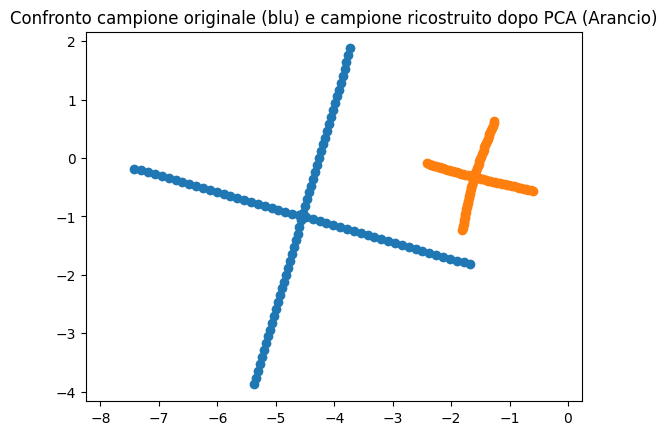

In [54]:

i = np.random.randint(low=1, high=1000)

projected = proiezioni_train.dot(base_train.T)
projected_example_train = projected[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo PCA (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)

---

## Feature selection e valutazione


* Sia gli alberi decisionali singoli (Decision Tree) sia gli ensemble basati su di essi (Random Forest) forniscono automaticamente una misura di importanza di ciascuna feature
* Utilizziamo Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

* Dopo aver addestrato il modello sul train set, otteniamo le features più importanti, ottenute automaticamente dall'addestramento stesso

In [20]:
importances_rf = rf.feature_importances_

* Con questo metodo calcoliamo la soglia basata sul `percentile`:

Percentile 10% → trattandosi di 10 componenti, il 10° percentile corrisponde all’importanza del secondo elemento ordinato;
quindi mantieni le componenti dall’indice del 2° valore in poi (top 8 su 10 = 80 %).
e

In [21]:
threshold = np.percentile(importances_rf, 10)  # top 90%
mask = importances_rf >= threshold
print("Componenti mantenute:", np.where(mask)[0]) #Indicizzazione X[:, mask] filtra le colonne, riducendo dimensionalità e mantenendo solo quelle ritenute “importanti”.
X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:,  mask]

Componenti mantenute: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  37  39  41  42  43  45  47  49  50  51  53  55  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 137 139 140 141 143 144 145 146 147 148 149 151 153 155 157 158 159
 161 163 165 166 167 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]


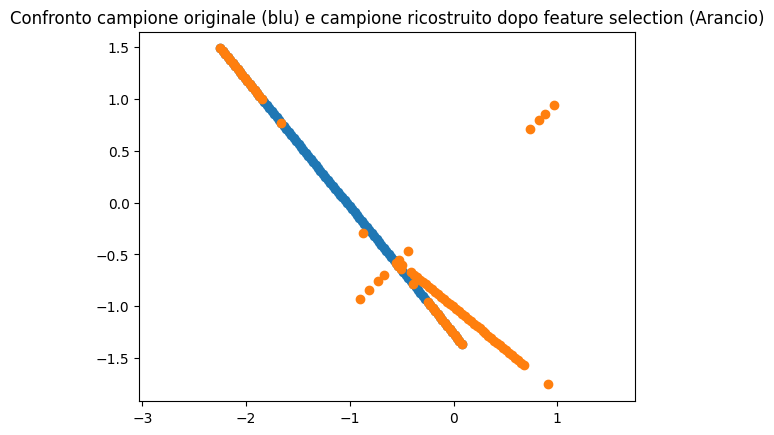

In [23]:
i = np.random.randint(low=1, high=4000)

projected_example_train = X_train_sel[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo feature selection (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)

---

## Estrazione e valutazione di nuove features

**Costruiamo un dataset separato con diverse features, per analizzare il comportamento diverso**
* Centroide
* Perimetro
* Area
* Distanza tra i punti estremi
* Compattezza

In [20]:
def extract_geometric_features(pts):
    """
    pts: array (n_punti, 2)
    Restituisce un dict con le feature geometriche.
    """
    # 1. Centroid
    cx, cy = pts.mean(axis=0)
    # distanze dal centroide
    dists = np.linalg.norm(pts - (cx, cy), axis=1)
    dist_mean = dists.mean()
    dist_std  = dists.std()

    # 2. Perimetro
    diffs = np.diff(pts, axis=0, append=pts[:1])
    perimeter = np.linalg.norm(diffs, axis=1).sum()

    # 3. Area (shoelace)
    x, y = pts[:,0], pts[:,1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    # 5. Extreme distances
    # (costo O(n^2), per n~100 va bene)
    dists_all = [np.linalg.norm(p-q) for p, q in combinations(pts, 2)]
    d_max = max(dists_all)
    d_min = min(dists_all)

    # 7. Compactness
    compactness = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0

    feats = {
        'dist_mean': dist_mean,
        'dist_std':  dist_std,
        'perimeter': perimeter,
        'area':      area,
        'd_max':     d_max,
        'd_min':     d_min,
        'compactness': compactness,
    }
    return feats
    

* Costruiamo ora il nuovo dataset 

In [21]:
features_list = []
for shape, lbl in zip(X, y):
    feats = extract_geometric_features(shape)
    feats['label'] = lbl
    features_list.append(feats)
df_geo = pd.DataFrame(features_list) 

In [22]:
df_geo.to_csv('dataset_geo.csv', index=False) # Esportazione del dataset con le feature geometriche

---

## Analisi della rappresentazione alternativa delle forme

In [16]:
X_alternative = ottieni_features_2(X)
print("Shape di X_alternative:", X_alternative.shape)

Shape di X_alternative: (4000, 99)


In [17]:
X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X_alternative, y
)

* Standardizziamo le componenti, poichè presentano valori diversi tra loro

In [18]:
X_train_alt_std = StandardScaler().fit_transform(X_train_alt)
X_test_alt_std = StandardScaler().fit_transform(X_test_alt)

In [26]:
param_grid_mlp_alt = {
    'hidden_layer_sizes': [(10,), (20,), (50,)],
    'activation': ['logistic'],
    'solver': ['adam'],  # 'adam' è il gradient descent, migliorato rispetto a 'sgd'
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100, 200, 300]
}

In [27]:
gs_mlp_alt = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp_alt,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

In [28]:
print("Tuning MLP...")
gs_mlp_alt.fit(X_train_alt_std, y_train_alt)

Tuning MLP...


GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(10,), (20,), (50,)],
                         'max_iter': [100, 200, 300], 'solver': ['adam']},
             scoring='accuracy')

In [30]:
y_pred_mlp_alt = gs_mlp_alt.predict(X_test_alt_std)

**Confusion Matrix**

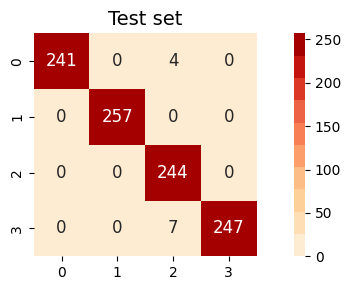

In [31]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test_alt, y_pred_mlp_alt),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

---

# 2. **Costruzione e valutazione di classificatori**

## Valutazione sul dataset FLAT

* Ottenimento dei dati ridotti dalle trasformazioni `PCA`

In [55]:
X_train_pca = proiezioni_train
X_test_pca  = proiezioni_test

### *Generazione del GridSearch per ottimizzazione iperparametri*

In [56]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 500, 1000],
    'multi_class': ['ovr', 'multinomial'],
}
param_grid_svm = {
    'C': [20, 50, 70],
    'gamma': [0.001, 0.002, 0.005],
    'kernel': ['rbf'],
}
param_grid_mlp = {
    'hidden_layer_sizes': [(10,), (20,), (50,)],
    'activation': ['logistic'],
    'solver': ['adam'],  # 'adam' è il gradient descent, migliorato rispetto a 'sgd'
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100, 200, 300]
}

In [57]:
gs_lr = GridSearchCV(
    LogisticRegression(solver='sag', random_state=42),
    param_grid_lr,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_mlp = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

In [58]:
print("Tuning Logistic Regression...")
gs_lr.fit(X_train_pca, y_train)
print("Tuning SVM...")
gs_svm.fit(X_train_pca, y_train)
print("Tuning MLP...")
gs_mlp.fit(X_train_pca, y_train)

Tuning Logistic Regression...
Tuning SVM...
Tuning MLP...


GridSearchCV(cv=7, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(10,), (20,), (50,)],
                         'max_iter': [100, 200, 300], 'solver': ['adam']},
             scoring='accuracy')

In [59]:
print("\nBest LR params:", gs_lr.best_params_)
print("Best score:",    gs_lr.best_score_)

print("\nBest SVM params:", gs_svm.best_params_)
print("Best score:",      gs_svm.best_score_)

print("\nBest MLP params:", gs_mlp.best_params_)
print("Best score:",      gs_mlp.best_score_)


Best LR params: {'C': 0.1, 'max_iter': 100, 'multi_class': 'multinomial'}
Best score: 0.46392857142857136

Best SVM params: {'C': 70, 'gamma': 0.005, 'kernel': 'rbf'}
Best score: 0.8267857142857142

Best MLP params: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'max_iter': 300, 'solver': 'adam'}
Best score: 0.9353571428571428


### *Logistic Regression*

In [60]:

best_lr = gs_lr.best_estimator_
y_test_pred_lr = best_lr.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr, digits=3))

Val Acc: 0.3175
              precision    recall  f1-score   support

           0      0.283     0.283     0.283       300
           1      0.244     0.167     0.198       300
           2      0.292     0.413     0.342       300
           3      0.452     0.407     0.428       300

    accuracy                          0.318      1200
   macro avg      0.318     0.318     0.313      1200
weighted avg      0.318     0.318     0.313      1200



**Confusion Matrix**

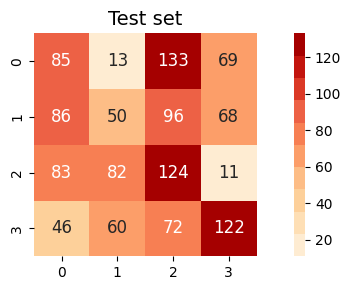

In [61]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_lr),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = plt.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.35, 0.95, 256)))

**Curva ROC**

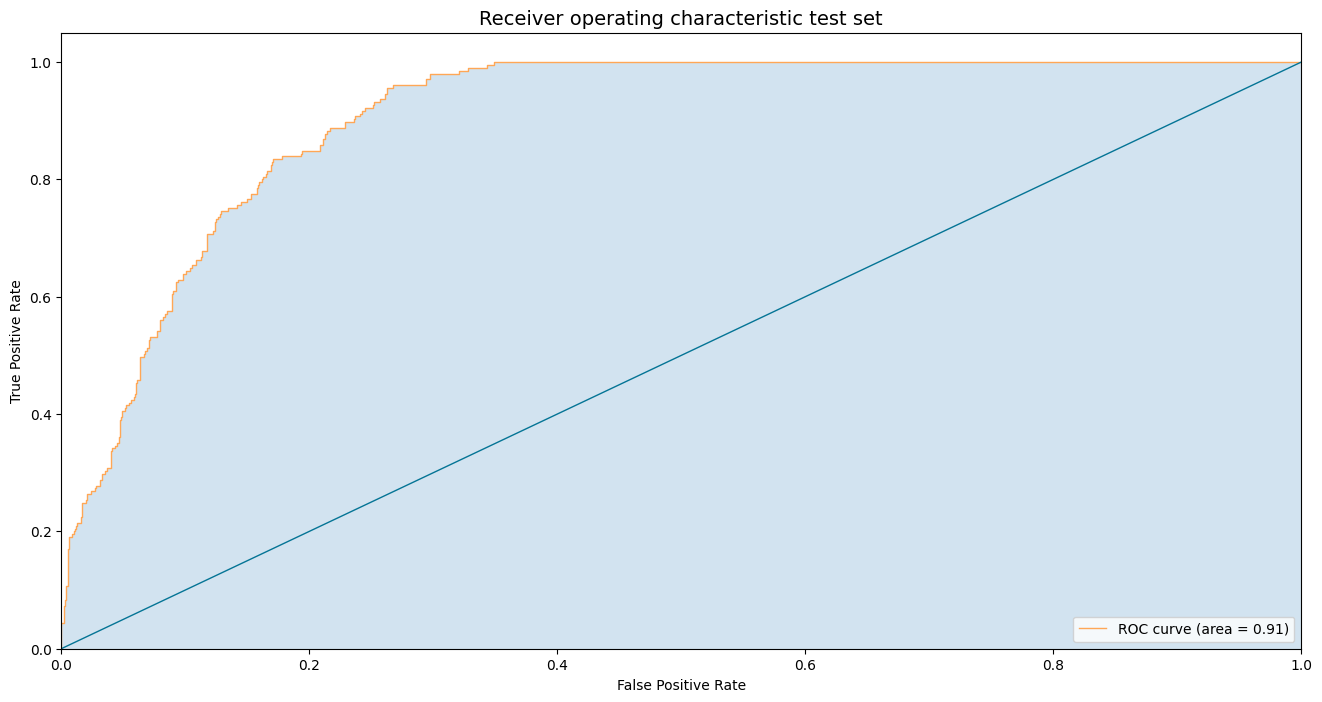

In [63]:
fpr, tpr, thresholds = roc_curve(y_test_pred_lr, gs_lr.predict_proba(X_test_pca)[:,1], pos_label=1)
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, color=colors[0], linewidth=1,label='ROC curve (area = %0.2f)' %  auc(fpr, tpr))
plt.fill_between(fpr, 0, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], color=colors[1], linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel(r'True Positive Rate')
plt.xlabel(r'False Positive Rate')
plt.title('Receiver operating characteristic test set', fontsize=14)
plt.legend(loc="lower right")
plt.show()

### *Support Vector Machines*

In [64]:
best_svm = gs_svm.best_estimator_
y_test_pred_svm = best_svm.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_svm))
print(classification_report(y_test, y_test_pred_svm, digits=3))

Val Acc: 0.5458333333333333
              precision    recall  f1-score   support

           0      0.668     0.597     0.630       300
           1      0.436     0.770     0.557       300
           2      0.678     0.407     0.508       300
           3      0.554     0.410     0.471       300

    accuracy                          0.546      1200
   macro avg      0.584     0.546     0.542      1200
weighted avg      0.584     0.546     0.542      1200



**Confusion Matrix**

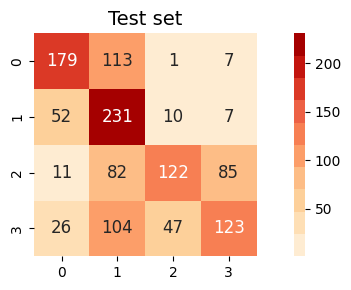

In [65]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_svm),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

### *Rete Neurale MLP*

In [66]:
best_mlp = gs_mlp.best_estimator_
y_test_pred_mlp = best_mlp.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_mlp))
print(classification_report(y_test, y_test_pred_mlp, digits=3))

Val Acc: 0.56
              precision    recall  f1-score   support

           0      0.436     0.827     0.571       300
           1      0.743     0.473     0.578       300
           2      0.689     0.510     0.586       300
           3      0.592     0.430     0.498       300

    accuracy                          0.560      1200
   macro avg      0.615     0.560     0.558      1200
weighted avg      0.615     0.560     0.558      1200



**Confusion Matrix**

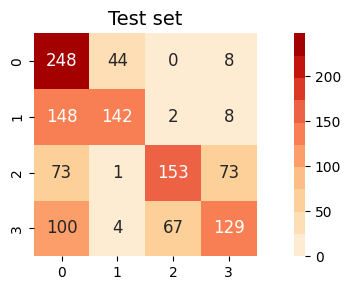

In [67]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()